# RandomForestXGBoost.ipynb:

This notebook contains the feature creation and implementation of the random forest and xgboost models. I have been using it mostly for running CV, but also to generate solutions.

You will find all of the features (excluding the PCA) and models. The parameters of the XGBoost model have been tuned.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import rcParams
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import numba
from scipy.stats import pearsonr

# Set false to run solution
run_cv = True

%reload_ext autotime
%matplotlib inline

/home/kkirchhoff/Programming/Python/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Set figsize for viewing feature importances with xgboost
rcParams['figure.figsize'] = 20, 20

time: 1.94 ms


## CSV Files:

### CV Files
 - cv_train_preprocessed1.csv:
  - CV file, created from act_train.csv. Split by people_id in same portion as act_train
  - Contains PCA features from char_10-char_37 in people file
 - cv_test_preprocessed-interp.csv:
  - CV file from act_train.csv. Split by people_id in same portaion as act_test
  - Contains PCA features from char_10-char_37 in people file
  - Also contains values calculated from interpolating using the leak data
   - Link to interpolation method: https://www.kaggle.com/loisso/predicting-red-hat-business-value/lb-0-987-group-1-and-date-trick/discussion

### Train/Test Files
 - train_pca.csv:
  - act_train.csv with PCA features from people file
 - test_pca_outcome.csv:
  - act_test.csv with PCA features from people file
  - Contains outcome values obtained from leak
  
### PCA Files
 - people_pca_char1-9.csv:
  - PCA of char_1-char_9 in people file
 - char_act_pca_2.csv:
  - PCA of char_1-char_10 in act_train merged with act_test
 - dummy_people_pca.csv:
  - PCA of people file with one-hot encoding

In [3]:
if run_cv == True:
    train = pd.read_csv('cv_files/cv_train_preprocessed1.csv')
    test = pd.read_csv('cv_files/cv_test_preprocessed-interp.csv')
else:
    train = pd.read_csv('train_pca.csv')
    test = pd.read_csv('test_pca_outcome.csv')

people_pca = pd.read_csv('people_pca_char1-9.csv')
char_pca = pd.read_csv('char_act_pca_2.csv')
dummy_pca = pd.read_csv('dummy_people_pca.csv')

time: 19.9 s


# Feature Creation

In [4]:
# Merge the train/test files with the PCA files

if run_cv == True:
    train['char_act_pca0'] = char_pca[:len(train)]['char_act_pca0'].values
    train['char_act_pca1'] = char_pca[:len(train)]['char_act_pca1'].values
    test['char_act_pca0'] = char_pca[len(train):]['char_act_pca0'].values
    test['char_act_pca1'] = char_pca[len(train):]['char_act_pca1'].values

train = pd.merge(train, people_pca, on='people_id', how='left')
test = pd.merge(test, people_pca, on='people_id', how='left')

train = pd.merge(train, dummy_pca, on='people_id', how='left')
test = pd.merge(test, dummy_pca, on='people_id', how='left')

time: 2.45 s


In [5]:
# Convert all of the boolean features to int

train['char_10_y'] = train['char_10_y'].apply(int)
test['char_10_y'] = test['char_10_y'].apply(int)
for i in range(11, 38):
    train['char_{}'.format(i)] = train['char_{}'.format(i)].apply(int)
    test['char_{}'.format(i)] = test['char_{}'.format(i)].apply(int)

time: 12.5 s


In [6]:
# get_date recreats the date because I accidently saved the files after dropping it.
@numba.jit
def get_date(x):
    if x[1] < 10:
        month = '0' + str(x[1])
    else:
        month = str(x[1])
    if x[2] < 10:
        day = '0' + str(x[2])
    else:
        day = str(x[2])
    year = str(x[0])
    return year + '-' + month + '-' + day

train['date'] = map(get_date, train[['year_x', 'month_x','day_x']].values)
test['date'] = map(get_date, test[['year_x', 'month_x','day_x']].values)

# The outcome dictionary holds the group_1/date combinations and their outcome from the train file
# This is how the value are obtained from the leak
outcome = {}
for row in train[['group_1', 'date', 'outcome']].values:
    outcome[(row[0], row[1])] = row[2]

# If the outcome is unknown it is assigned -1
def get_outcome(x):
    try:
        return outcome[tuple(x)]
    except:
        return -1

time: 27.9 s


In [7]:
# Get people date
train['date_y'] = map(get_date, train[['year_y', 'month_y','day_y']].values)
test['date_y'] = map(get_date, test[['year_y', 'month_y','day_y']].values)

time: 24.4 s


In [8]:
# Since the leak revealed the outcome for a decent portion of the test file,
# I appended the rows with known outcome into the train dataframe and removed them from the test dataframe
if run_cv == True:
    test.rename(columns={'outcome':'outcome_1'},inplace=True)
    test['outcome'] = map(get_outcome, test[['group_1', 'date']].values)
    train = train.append(test[test.outcome!=-1].drop(['outcome', 'outcome_interp'], axis=1).rename(columns={'outcome_1':'outcome'}))
else:
    train = train.append(test[test.outcome!=-1])

time: 4.2 s


In [9]:
test = test[test.outcome==-1]

time: 75.6 ms


In [10]:
# Characteristic features from the activity files
val_list = ['activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x',
            'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x']

# Characteristic features from the people file
char_list = ['char_10_y', 'char_11', 'char_12',
             'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18',
             'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24',
             'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_30',
             'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37']

# Mean character type number
@numba.jit
def get_char(vals):
    if vals[0] == 1:
        return np.mean(vals[1:9])
    else:
        return vals[10]

# Number of true values in people char_10-char_37
@numba.jit
def get_true(vals):
    i = 0
    for v in vals:
        if v == True:
            i +=1
    return i

# Number of false values in people char_10-char_37
@numba.jit
def get_false(vals):
    i = 0
    for v in vals:
        if v == False:
            i += 1
    return i

# Number of true values - number of false values
@numba.jit
def get_bool_diff(vals):
    i = 0
    for v in vals:
        if v == True:
            i += 1
        elif v == False:
            i -= 1
    return i

# Get the difference between the dates in the people and activity files
@numba.jit
def get_date_diff(d1, d2):
    d = 0
    for i in range(3):
        d += np.abs(d1[i] - d2[i])
    return d

# Converts the date to number of days since 2002
@numba.jit
def get_date_num(d):
    d1 = 0
    d[0] = (d[0] - 2020)*365
    d[1] = d[1]*30
    for i in range(3):
        d1 += d[i]
    return d1

# Ratio of days
@numba.jit
def get_date_rat(d1, d2):
    d1_num = get_date_num(d1)
    d2_num = get_date_num(d2)
    return d1_num/d2_num

# Sum of binary values in people file
@numba.jit
def binary_sum(row):
    bsum = 0
    for val in row:
        bsum += val
    return bsum

time: 87.4 ms


In [11]:
# Generate the features from the functions above
train['char_x'] = map(get_char, train[val_list].values)
test['char_x'] = map(get_char, test[val_list].values)
train['true_count'] = map(get_true, train[char_list].values)
train['false_count'] = map(get_false, train[char_list].values)
test['true_count'] = map(get_true, test[char_list].values)
test['false_count'] = map(get_false, test[char_list].values)
train['bool_count'] = map(get_bool_diff, train[char_list].values)
test['bool_count'] = map(get_bool_diff, test[char_list].values)
train['binary_sum'] = map(binary_sum, train[['char_10_y'] + ['char_{}'.format(i) for i in range(11, 38)]].values)
test['binary_sum'] = map(binary_sum, test[['char_10_y'] + ['char_{}'.format(i) for i in range(11, 38)]].values)

time: 20.2 s


In [12]:
# Dictionaries containing the outcome mean and count by date
date_mean_y = train.groupby('date_y')['outcome'].mean().to_dict()
date_mean = train.groupby('date')['outcome'].mean().to_dict()

date_count_y = train.groupby('date_y')['outcome'].count().to_dict()
date_count = train.groupby('date')['outcome'].count().to_dict()

date_mean['2022-01-16'] = 0.
date_mean_y['2022-01-16'] = 0.
date_count['2022-01-16'] = 0.
date_count_y['2022-01-16'] = 0.

time: 1.66 s


In [13]:
# Get date mean and count from above dictionaries
train['date_mean'] = train.date.apply(lambda x: date_mean[x])
test['date_mean'] = test.date.apply(lambda x: date_mean[x])

train['date_mean_y'] = train.date_y.apply(lambda x: date_mean_y[x])
test['date_mean_y'] = test.date_y.apply(lambda x: date_mean_y[x])

train['date_count'] = train.date.apply(lambda x: date_count[x])
test['date_count'] = test.date.apply(lambda x: date_count[x])

train['date_count_y'] = train.date_y.apply(lambda x: date_count_y[x])
test['date_count_y'] = test.date_y.apply(lambda x: date_count_y[x])

time: 3.37 s


In [14]:
# Label encode categorical features
# Each feature has a new label encoder to decode if needed
le = preprocessing.LabelEncoder()
le.fit(list(train.people_id.unique()) + list(test.people_id.unique()))
train['people'] = le.transform(train['people_id'])
test['people'] = le.transform(test['people_id'])

le2 = preprocessing.LabelEncoder()
le2.fit(list(train['activity_id'].unique()) + list(test['activity_id'].unique()))
train['activity'] = le2.transform(train['activity_id'])
test['activity'] = le2.transform(test['activity_id'])

le3 = preprocessing.LabelEncoder()
le3.fit(list(train['date'].unique()) + list(test['date'].unique()))
train['date'] = le3.transform(train['date'])
test['date'] = le3.transform(test['date'])

le4 = preprocessing.LabelEncoder()
le4.fit(list(train['date_y'].unique()) + list(test['date_y'].unique()))
train['date_y'] = le4.transform(train['date_y'])
test['date_y'] = le4.transform(test['date_y'])

time: 31.6 s


In [15]:
# Get date features from functions above
train['date_num'] = map(get_date_num, train[['year_x', 'month_x', 'day_x']].values)
test['date_num'] = map(get_date_num, test[['year_x', 'month_x', 'day_x']].values)

train['date_diff'] = map(get_date_diff, train[['year_x', 'month_x', 'day_x']].values,
                         train[['year_y', 'month_y', 'day_y']].values)
test['date_diff'] = map(get_date_diff, test[['year_x', 'month_x', 'day_x']].values,
                        test[['year_y', 'month_y', 'day_y']].values)

train['date_rat'] = map(get_date_diff, train[['year_x', 'month_x', 'day_x']].values,
                         train[['year_y', 'month_y', 'day_y']].values)
test['date_rat'] = map(get_date_diff, test[['year_x', 'month_x', 'day_x']].values,
                        test[['year_y', 'month_y', 'day_y']].values)

time: 13.5 s


In [16]:
# Generate features from sums
train['char_sum'] = map(sum, train[['char_{}_y'.format(i) for i in range(1,10)]].values)
test['char_sum'] = map(sum, test[['char_{}_y'.format(i) for i in range(1,10)]].values)

train['char_pca_sum'] = map(sum, train[['char_pca{}'.format(i) for i in range(10)]].values)
test['char_pca_sum'] = map(sum, test[['char_pca{}'.format(i) for i in range(10)]].values)

time: 17 s


In [17]:
# Scale char_38 by dividing by 100 (max value)
# Improves some model performances
train['char_38_scaled'] = train['char_38'].apply(lambda x: float(x/100.))
test['char_38_scaled'] = test['char_38'].apply(lambda x: float(x/100.))

time: 775 ms


In [18]:
# Get feature from mean outcome by char_38

char_mean = train.groupby('char_38')['outcome'].mean().to_dict()
def get_char_mean(x):
    try:
        return char_mean[tuple(x)]
    except:
        return 0.

time: 769 ms


In [19]:
train['char_mean'] = train['char_38'].apply(get_char_mean)
test['char_mean'] = test['char_38'].apply(get_char_mean)

time: 3.29 s


In [20]:
# Fill N/A values with arbitrary number (-999) has performed the best
# Dropping N/A will remove every column, since activity files all have N/A based on the activity type
train.fillna(-999, inplace=True)
test.fillna(-999, inplace=True)

time: 1.22 s


In [21]:
# X_all contains all of the features generated and the PCA features
# Use this to get most important features after running the model
X_all = ['activity_category',
         'activity',
         'people',
         'char_x',
         'year_x',
         'month_x',
         'day_x',
         'date',
         'date_y',
         'group_1',
         'dummy_pca_0',
         'dummy_pca_1',
         #'people_char_pca_0',
         #'people_char_pca_1',
         #'people_char_pca_2',
         'char_2_y',
         'char_10_y',
         'char_3_y',
         'char_4_y',
         'char_5_y',
         'char_6_y',
         'char_7_y',
         'char_8_y',
         'char_9_y',
         'char_pca0',
         'char_pca1',
         'char_pca2',
         'char_pca3',
         'char_pca4',
         'char_pca5',
         'char_pca6',
         'char_pca7',
         'char_pca8',
         'char_pca9',
         'char_sum',
         'char_pca_sum',
         'char_38',
         'unique_group',
         'unique_char10',
         'char_act_pca0',
         'char_act_pca1',
         'date_diff',
         'date_num',
         'date_rat',
         'date_mean',
         'date_mean_y',
         'date_count',
         'date_count_y',
         'true_count',
         'false_count',
         'bool_count',
         #'char_act_pca2'
         'binary_sum',
         'char_mean'
         #'activity_count'
        ]
X_all = X_all + ['char_{}'.format(i) for i in range(11,38)] + ['char_{}_x'.format(i) for i in range(1,10)]
y = 'outcome'

time: 31.6 ms


# Random Forest Model

In [52]:
# Random forest model
# I use n_estimators=400 for CV
# Real solution has n_estimators=1500
clf = RandomForestClassifier(n_estimators=400, verbose=2, n_jobs=5, random_state=42)

time: 2.43 ms


In [56]:
clf.set_params(n_estimators=1000, verbose=1, n_jobs=5, random_state=42)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=5,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

time: 6.96 ms


In [57]:
# Fit model
clf.fit(train[X_rf], train[y])

building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   35.7s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  2.6min


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  6.1min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=5)]: Done 400 out of 400 | elapsed:  6.9min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=5,
            oob_score=False, random_state=42, verbose=2, warm_start=False)

time: 6min 54s


In [54]:
# Get prediction. We want the probability of outcome being 1
pred = clf.predict_proba(test[X_rf])
pred1 = pred[:,1]

[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:    0.6s


time: 1.17 s


[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:    1.0s finished


In [55]:
# Get the AUC score of the prediction
roc_auc_score(test['outcome_1'], pred1)
# top: 0.86696970648515448

0.79313538954943297

time: 5.17 ms


In [50]:
# Get the most important features after fitting the random forest model
X_rf = [x[0] for x in sorted(zip(X_all1,clf.feature_importances_), key=lambda xx: xx[1])][-25:]
X_rf

['activity',
 'char_act_pca1',
 'char_4_y',
 'date_count',
 'date_mean',
 'char_3_y',
 'date',
 'date_num',
 'char_8_y',
 'date_count_y',
 'true_count',
 'false_count',
 'date_y',
 'binary_sum',
 'char_sum',
 'people',
 'char_6_y',
 'bool_count',
 'date_mean_y',
 'char_7_y',
 'dummy_pca_1',
 'dummy_pca_0',
 'char_2_y',
 'group_1',
 'char_38_scaled']

time: 686 ms


In [23]:
# Best performing random forest features that I have found
X_rf = ['date_mean',
         'char_pca5',
         'char_5_y',
         'char_4_y',
         'char_3_y',
         'char_9_y',
         'char_pca_sum',
         'binary_sum',
         'bool_count',
         'date',
         'true_count',
         'date_num',
         'char_8_y',
         'false_count',
         'date_y',
         'char_6_y',
         'date_count_y',
         'people',
         'char_sum',
         'char_pca0',
         'char_7_y',
         'date_mean_y',
         'char_2_y',
         'group_1',
         'char_38_scaled']
X_rf

['date_mean',
 'char_pca5',
 'char_5_y',
 'char_4_y',
 'char_3_y',
 'char_9_y',
 'char_pca_sum',
 'binary_sum',
 'bool_count',
 'date',
 'true_count',
 'date_num',
 'char_8_y',
 'false_count',
 'date_y',
 'char_6_y',
 'date_count_y',
 'people',
 'char_sum',
 'char_pca0',
 'char_7_y',
 'date_mean_y',
 'char_2_y',
 'group_1',
 'char_38_scaled']

time: 130 ms


# XGBoost Model

In [22]:
# Create DMatrix for xgboost
# Initially set X_xgb to X_all. Train the model, get the most important features and recreate dtrain/dtest
X_xgb = X_all
dtrain = xgb.DMatrix(train[X_xgb], label=train[y], missing=-999, feature_names=X_xgb)
dtest = xgb.DMatrix(test[X_xgb], label=test['outcome_1'], missing=-999, feature_names=X_xgb)

time: 8.27 s


In [23]:
# Best performing parameters
params = {
    "n_estimators":20,
    "nthread":5,
    "objective": "binary:logistic",
    "max_depth": 35,
    #"gamma":0.1,
    #"lambda":0.8,
    "alpha":0.1,
    #"booster" : "gbtree",
    "eval_metric": "auc",
    #"eta": 0.25,
    "tree_method": 'exact',
    #"subsample": 0.7,
    #"colsample_bytree": 0.7,
    "silent": 0
}
watchlist = [(dtest, 'eval')]

time: 6.71 ms


In [24]:
# Train the xgboost model
gbm = xgb.train(params=params, dtrain=dtrain, num_boost_round=300, evals=watchlist, early_stopping_rounds=5,
                verbose_eval=True)

[0]	eval-auc:0.742668
Will train until eval-auc hasn't improved in 5 rounds.
[1]	eval-auc:0.762115
[2]	eval-auc:0.785864
[3]	eval-auc:0.798143
[4]	eval-auc:0.801476
[5]	eval-auc:0.80308
[6]	eval-auc:0.805859
[7]	eval-auc:0.808213
[8]	eval-auc:0.812026
[9]	eval-auc:0.812419
[10]	eval-auc:0.815032
[11]	eval-auc:0.819707
[12]	eval-auc:0.822733
[13]	eval-auc:0.824201
[14]	eval-auc:0.826853
[15]	eval-auc:0.827457
[16]	eval-auc:0.826543
[17]	eval-auc:0.828383
[18]	eval-auc:0.829879
[19]	eval-auc:0.830047
[20]	eval-auc:0.830418
[21]	eval-auc:0.83169
[22]	eval-auc:0.833172
[23]	eval-auc:0.833469


KeyboardInterrupt: 

time: 7min 24s


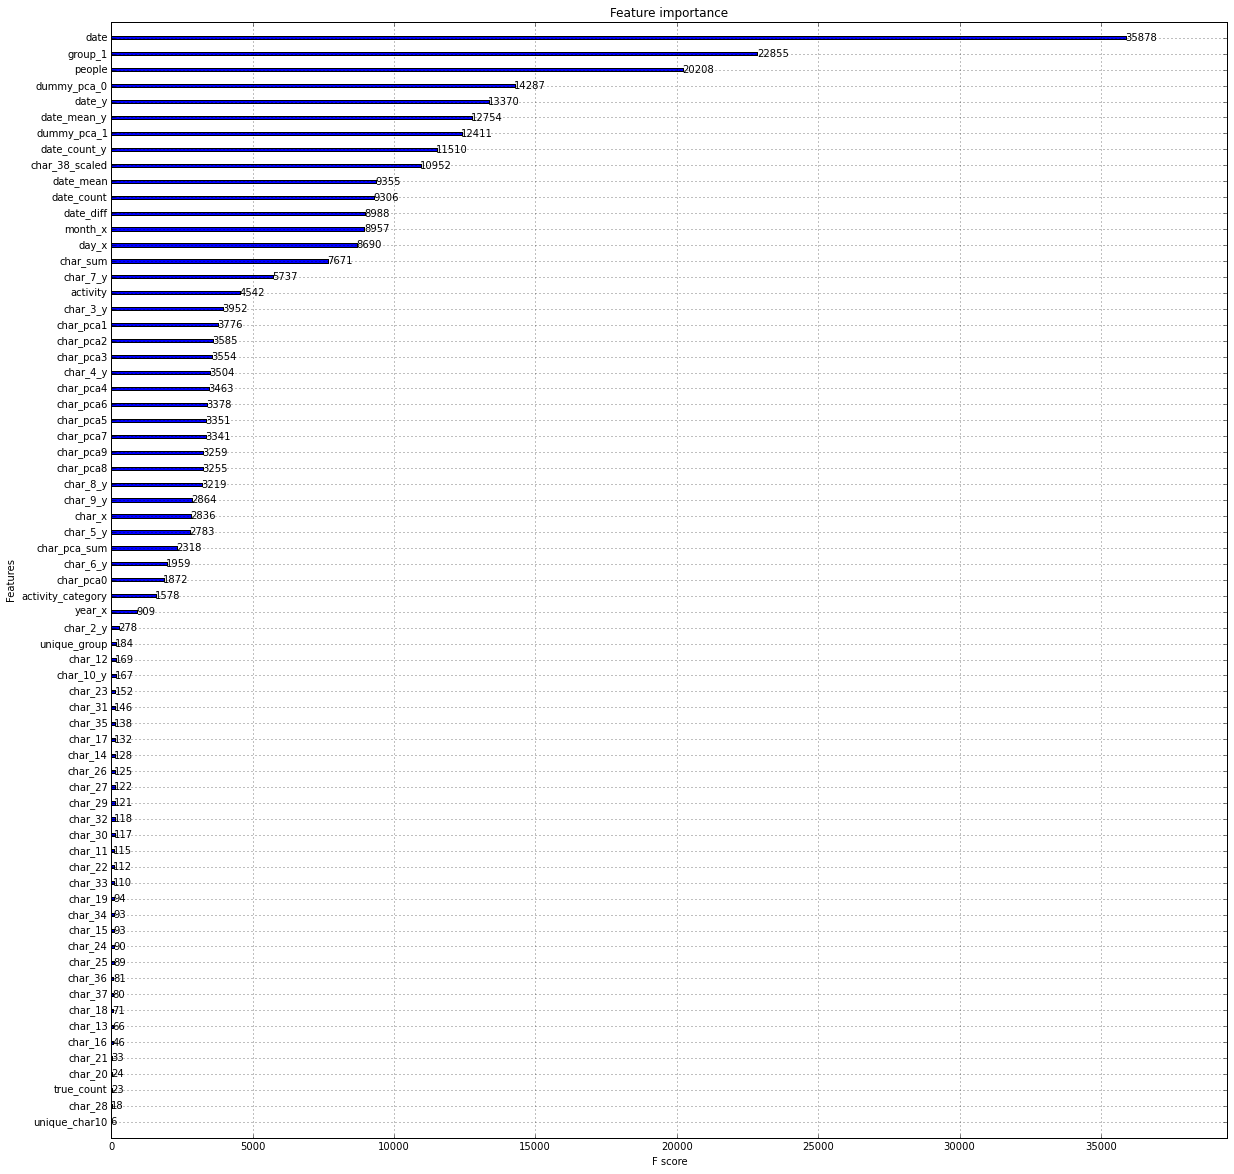

time: 2.33 s


In [35]:
# Feature importances
xgb.plot_importance(gbm)

In [37]:
# Reassign most important features to X_xgb to reduce dimensions
# Comment out X_xgb=X_all and recreate dtrain/dtest above
X_xgb = [x[0] for x in sorted(gbm.get_fscore().items(), key=lambda xx: xx[1])][-30:]
X_xgb

['char_10_y',
 'char_12',
 'unique_group',
 'char_2_y',
 'year_x',
 'activity_category',
 'char_6_y',
 'char_5_y',
 'char_x',
 'char_9_y',
 'char_8_y',
 'char_4_y',
 'char_3_y',
 'activity',
 'char_7_y',
 'char_sum',
 'day_x',
 'month_x',
 'date_diff',
 'date_count',
 'date_mean',
 'char_38_scaled',
 'date_count_y',
 'dummy_pca_1',
 'date_mean_y',
 'date_y',
 'dummy_pca_0',
 'people',
 'group_1',
 'date']

time: 4.44 s


In [40]:
# Predict dtest
pred2 = gbm.predict(dtest)

time: 4.27 ms


In [41]:
# Get AUC score
roc_auc_score(test['outcome_1'], pred2)

# top: 0.87201777216771759

0.85764040943053221

time: 273 ms


# Generate Submission

In [24]:
# This is for generating submission only
submission = pd.DataFrame()
submission['activity_id'] = test['activity_id']
submission['outcome'] = pred4

time: 15.8 ms


In [25]:
# Since we merged the test rows with known outcomes into the train dataframe we need to reread the test file
test2 = pd.read_csv('test_pca_outcome.csv')
# Append known outcome values from test file
submission = submission.append(test2[test2.outcome!=-1][['activity_id', 'outcome']])

time: 4.31 s


In [26]:
# Write submission
# My filename convention has been "submission<submission number>-<parameters>-<unique features to this solution>.csv"
submission.to_csv('submission-xgboost-n_est20-max_depth35-alpha0.1-outcome-dates-2.csv', index=False)

time: 1.2 s
